# Step 3 - Climate Analysis
Clint Goodman

In [1]:
#Set environment
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect, and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [2]:
#Create database, setup connection to database, create ORM classes for se

engine = create_engine('sqlite:///Resources/hawaii.sqlite')
conn = engine.connect()
Base = automap_base()
Base.metadata.create_all(engine)
Base.prepare(engine, reflect=True)

In [3]:
#verify the names of the tables in the database
#Base.classes.keys()

In [4]:
Measurement = Base.classes.measurements
Station = Base.classes.stations
session = Session(bind=engine)
inspector = inspect(engine)

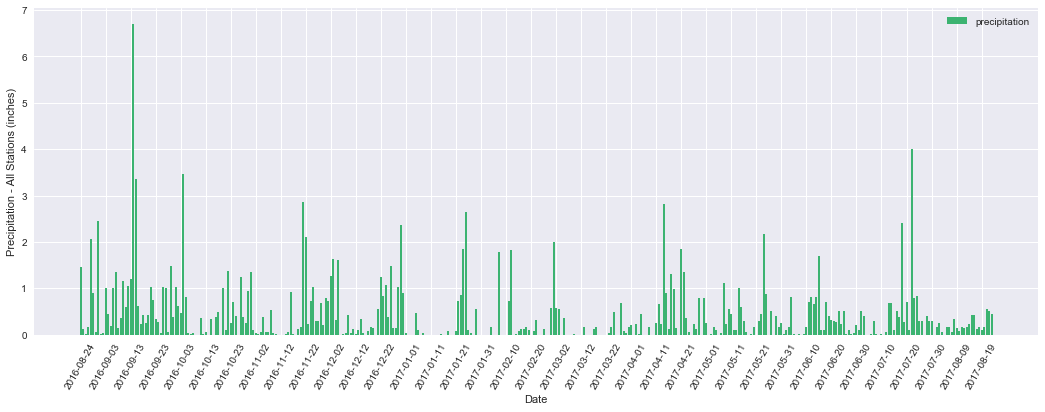

In [5]:
#Add additional libraries to environment for this portion of the work.
import datetime as dt
from sqlalchemy import func, distinct

# Determine the date of the most recent record in the Measurements database
# Subtract one year (365 days) from that date and convert it to a string
# Store date and prcp values for the previous one year (365 days) records
newestDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
yearData = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(yearData)


#Query database for one year of data from the end of the database. Group by used to calculate the total precipitation for the day (all stations)
pastResults = session.query(Measurement.date, Measurement.prcp).\
filter(func.strftime("%Y-%m-%d", Measurement.date) > yearData).\
group_by(Measurement.date).\
order_by(Measurement.date).all()

#Store the query results in a datafrme
dfResults = pd.DataFrame(pastResults, columns=['Date','Precipitation'])
dfResults.set_index('Date', inplace=True)

#Plot precipitation results on a bar chart.  Every tenth date was printed on the x axis to make the graph readable
x = np.arange(len(dfResults))
height = dfResults.loc[:,"Precipitation"].tolist()
allDates = dfResults.index.values

plt.figure(figsize=(18,6))

plt.bar(x, height, color='mediumseagreen',alpha=1, align="center", label="precipitation")
plt.ylabel("Precipitation - All Stations (inches)")
plt.xlabel("Date")
plt.xticks(np.arange(0,len(x),step=10), allDates[::10], rotation=60)
plt.legend()
#plt.tight_layout()
plt.savefig("Images/3.1_PrcpAnalysis.png")
plt.show()

In [6]:
#3.1 Precipitation Analysis (cont) - Summary Table of precipitation data
dfResults.describe()

,Precipitation
count,365.000000
mean,0.415736
std,0.687498
min,0.000000
25%,0.010000
50%,0.160644
75%,0.530000
max,6.700000


In [7]:
#3.2 Station Analysis - Station Count
#Option 1
stationCount = session.query(Measurement.station).distinct().count()
print(f'There are {stationCount} stations in this analysis.') 

# Option 2
# stationCount = session.query(Station).count()
# stationCount


There are 9 stations in this analysis.


In [8]:
# 3.2 Station Analysis (cont) - Design a query to find the most active stations.
stationActivity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
dfStationActivity = pd.DataFrame(stationActivity, columns=['Station','TOBS'])
dfStationActivity.head(10)
print(dfStationActivity)
print(f'Station {dfStationActivity.Station[0]} had the most temperature observations with {dfStationActivity.TOBS[0]}')


       Station  TOBS
0  USC00519281  2772
1  USC00519397  2724
2  USC00513117  2709
3  USC00519523  2669
4  USC00516128  2612
5  USC00514830  2202
6  USC00511918  1979
7  USC00517948  1372
8  USC00518838   511
Station USC00519281 had the most temperature observations with 2772


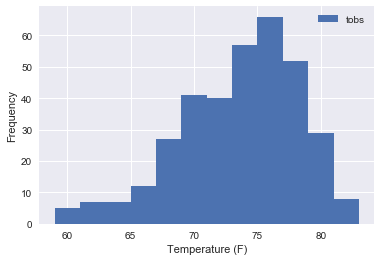

In [9]:
# 3.2 Station Analysis(cont) - Design a query to retrieve the last 12 months of temperature observation data (tobs)

tobFreq = session.query(Measurement.tobs).filter(func.strftime("%Y-%m-%d", Measurement.date) > yearData).filter(Measurement.station == "USC00519281").all()
#tobFreq
dftobFreq = pd.DataFrame(tobFreq, columns=['Temperature'])

tempList = dftobFreq.loc[:,"Temperature"].tolist()
tempList

fig, ax = plt.subplots()

ax.hist(tempList, label="tobs", bins=12)
ax.legend(loc=1)
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency")
fig.savefig('Images/3.2_12Mo_tobs.png')


First day of vacation (mm-dd) 05-01
Last day of vacation (mm-dd) 05-10
Your vacation starts 05-01 and ends 05-10
Average Temp for this time in 2017 was 75.11764705882354
Low Temp for this time in 2017 was 65
High Temp for this time in 2017 was 80


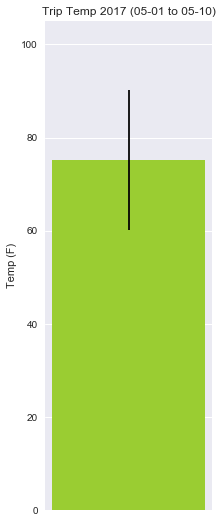

In [10]:
#3.3 - Temperature Analysis
def calc_temps(startDate, endDate):
    startDate = "2017-" + startDate
    endDate = "2017-" + endDate
    tripAdvisor = session.query(Measurement.date, Measurement.tobs).filter\
    (and_(func.strftime("%Y-%m-%d", Measurement.date) >= startDate,\
          func.strftime("%Y-%m-%d", Measurement.date) < endDate))\
    .order_by(Measurement.date).all()
    dftripAdvisor = pd.DataFrame(tripAdvisor, columns=['Date','Temp'])
    dftripAdvisor.head()
    avgTemp = dftripAdvisor.Temp.mean()
    minTemp = dftripAdvisor.Temp.min()
    maxTemp = dftripAdvisor.Temp.max()
    
    return (minTemp, avgTemp, maxTemp)

#Prompt user for start and end dates for vacation
start = input("First day of vacation (mm-dd) ")
end = input("Last day of vacation (mm-dd) ")
calc_temps(start, end)

#Unpackage return and print statements to screen
minTemp, avgTemp, maxTemp = calc_temps(start, end)
print(f'Your vacation starts {start} and ends {end}')
print(f'Average Temp for this time in 2017 was {avgTemp}')
print(f'Low Temp for this time in 2017 was {minTemp}')
print(f'High Temp for this time in 2017 was {maxTemp}')

#Build graphical representation of returned values
fig, ax = plt.subplots()
ax.bar(0, avgTemp, yerr=(maxTemp-minTemp), color='yellowgreen')
ax.set_xticks(ticks=[])
ax.set_ylabel("Temp (F)")
ax.set_title(f'Trip Temp 2017 ({start} to {end})')
ax.set_ylim(bottom=0, top=105)
fig.set_figwidth(3)
fig.set_figheight(9)
fig.savefig("images/3.3_TempAnalysis_tavg-tmin-max.png")


In [11]:
#3.4 Optional Queries

# Determine the date of the most recent record in the Measurements database
# Subtract one year (365 days) from that date and convert it to a string
# Store date and prcp values for the previous one year (365 days) records
newestDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
yearData = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(yearData)


#Query database for one year of data from the end of the database. Group by used to calculate the total precipitation for the day (all stations)
pastResults = session.query(\
                            Measurement.station, func.sum(Measurement.prcp)).\
filter(and_(func.strftime("%m-%d", Measurement.date) >= start,\
           func.strftime("%m-%d", Measurement.date) <= end)).\
group_by(Measurement.station).\
order_by(Measurement.station).all()

#Store the query results in a datafrme
dfResults = pd.DataFrame(pastResults, columns=['Station','Total Rainfall (in)'])
dfResults

,Station,Total Rainfall (in)
0,USC00511918,4.990644
1,USC00513117,15.160644
2,USC00514830,8.563861
3,USC00516128,35.351287
4,USC00517948,6.072227
5,USC00518838,5.883218
6,USC00519281,23.360000
7,USC00519397,5.651287
8,USC00519523,9.161287


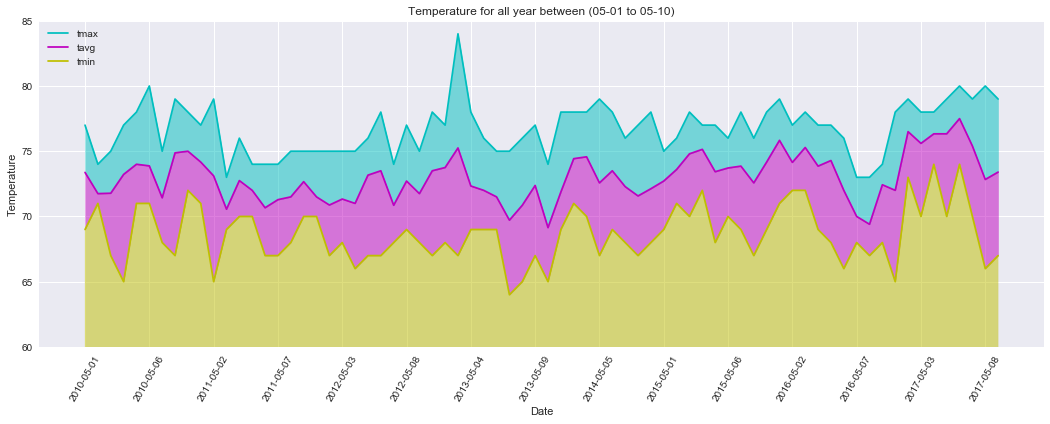

In [12]:
def daily_normals(startDate, endDate):
    #startDate = "2017-" + startDate
    #endDate = "2017-" + endDate
    tripAdvisor2 = session.query(\
                                 Measurement.date,\
                                 func.min(Measurement.tobs).label("tmin"),\
                                 func.avg(Measurement.tobs).label("tavg"),\
                                 func.max(Measurement.tobs).label("tmax"),).\
    filter(and_(func.strftime("%m-%d", Measurement.date) >= startDate,\
          func.strftime("%m-%d", Measurement.date) < endDate)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
    dftripAdvisor2 = pd.DataFrame(tripAdvisor2, columns=['Date','tmin','tavg','tmax'])
    dftripAdvisor2.set_index('Date', inplace=True)
    return (dftripAdvisor2)

#Call daily_normals function and send previously entered start and end dates for vacation
results = daily_normals(start, end)

x = np.arange(len(results))
y = [results.loc[:,"tmin"].tolist(), results.loc[:,"tavg"].tolist(), results.loc[:,"tmax"].tolist()]
allDates = results.index.values

plt.figure(figsize=(18,6))
#plt.stackplot(x, y, colors=['c','m','y'], labels=["tmin","tavg","tmax"])
#Comment - couldn't find stacked under stackplot.  You guys always say there are different ways to do things...


plt.plot(x, y[2], color='c',alpha=1, label="tmax")
plt.fill_between(x,y[2],y[1], color='c', alpha=0.5)

plt.plot(x, y[1], color='m',alpha=1, label="tavg")
plt.fill_between(x,y[1],y[0], color='m', alpha=0.5)

plt.plot(x, y[0], color='y',alpha=1,label="tmin")
plt.fill_between(x,y[0], color='y', alpha=0.5)

plt.title(f"Temperature for all year between ({start} to {end})")
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.ylim((60,85))
plt.xticks(np.arange(0,len(x),step=5), allDates[::5], rotation=60)
plt.legend(loc="upper left")
#plt.tight_layout()
plt.savefig("Images/Bonus.png")
plt.show()
